### First experiments with U-Net on CESM slp data

Trained model with **variable mask** and **augmentation factor 2** on samples with rel. amount of missing values in the **range of [0.75, 0.99]**.

Use this single model to find the **optimized sampling strategy** in a brute-force manner.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data
from models import build_unet_4conv
from relevance import compute_single_relevance_map

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [3]:
## Reload final model, trained on range:

# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-level-pressure' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'slp' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'CESM' # Choose Earth System Model, either 'FOCI' or 'CESM'.

mask_type = 'variable'
missing_type = 'range'
augmentation_factor = 2
run = '_final'

# Get path to stored validation loss from batch:
path_to_model = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)

print(path_to_model)

# Reload parameters for this experiment:
with open(path_to_model / 'parameters.json', 'r') as f:
    parameters=load(f)

train_val_split = parameters['train_val_split']
missing_values = parameters['missing_values']
scale_to = parameters['scale_to']

# Reload final model, trained on range:
model = tf.keras.models.load_model(path_to_model / 'missing_75_99' / 'model')

GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_factor_2_final


2023-01-27 14:52:16.716110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-01-27 14:52:16.716139: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-27 14:52:16.716157: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl108): /proc/driver/nvidia/version does not exist
2023-01-27 14:52:16.716364: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
## Load validation samples:

# Path to full data:
path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

# Load data:
data = load_data_set(data_path=path_to_data, data_source_name=source)

# Select single feature and compute anomalies, using whole time span as climatology:
data = get_anomalies(feature=feature, data_set=data)

# Create synthetic missing_mask of ONEs, to load FULL validation samples:
missing_mask_1 = np.ones(data.shape)

# Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    missing_mask_1,
    train_val_split, 
    scale_to
)

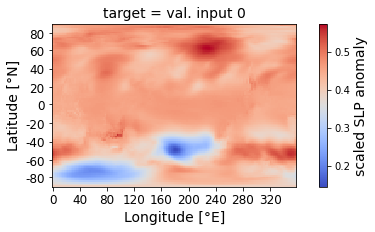

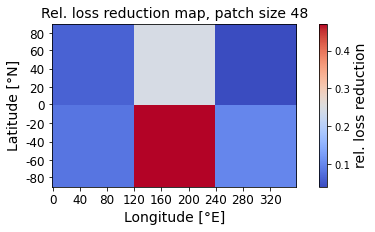

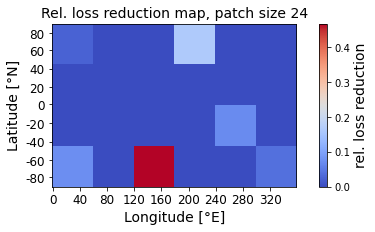

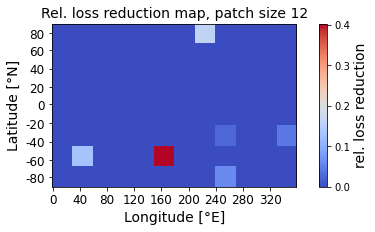

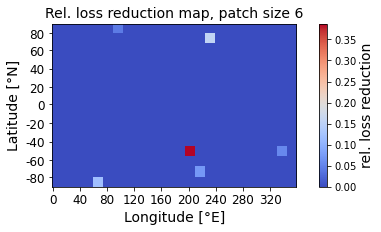

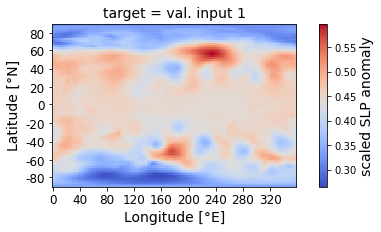

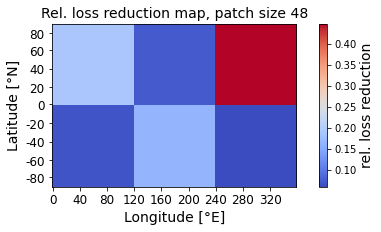

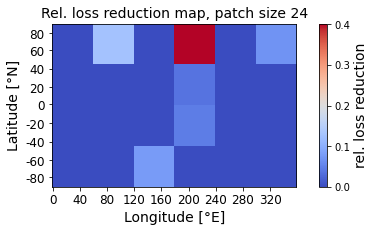

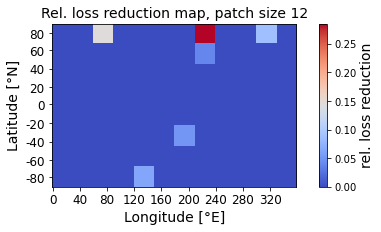

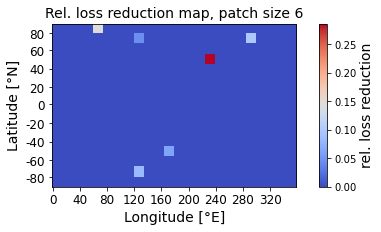

In [8]:
## Batch for first two validation samples and patch_sizes = [48, 24, 12, 6]:

# Define patch sizes:
patch_sizes = [48, 24, 12, 6]

# Define number of validation samples:
n_samples = 2

# Reload obtained rel. loss reduction maps:
rel_loss_reduction_maps = np.load(path_to_model / 'rel_loss_reduction_maps.npy')

# Loop over samples:
for n in range(n_samples):
    
    ## Plot target:

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_input[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)

    plt.title('target = val. input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
       
    plt.show()

    # Loop over patch sizes:
    for p in range(len(patch_sizes)):
        
        # Get current patch size:
        patch_size = patch_sizes[p]
   
        # Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
        fig, ax = plt.subplots(figsize=(8, 3))
        im = plt.imshow(rel_loss_reduction_maps[n,p,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
        cbar = plt.colorbar(im)
        cbar.set_label('rel. loss reduction', fontsize=14)
        plt.title('Rel. loss reduction map, patch size '+str(patch_size), fontsize=14)
        plt.xlabel('Longitude [°E]', fontsize=14)
        plt.ylabel('Latitude [°N]', fontsize=14)
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
        plt.show()

In [20]:
np.sum(rel_loss_reduction_maps[0,3])/(6**2)

0.8331036528568071

In [21]:
rel_loss_reduction_maps[0,3].shape

(96, 144)

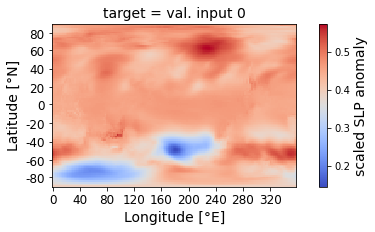

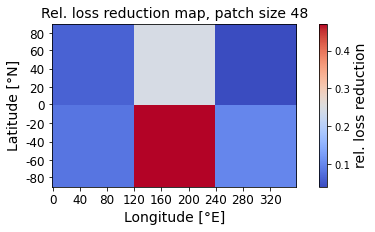

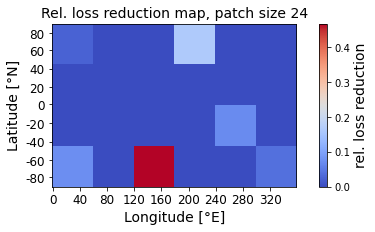

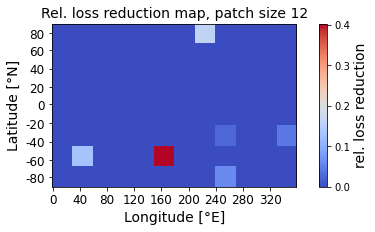

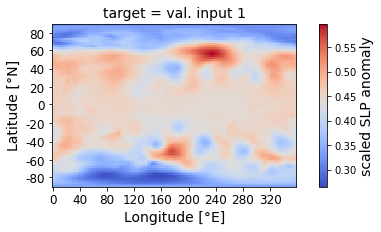

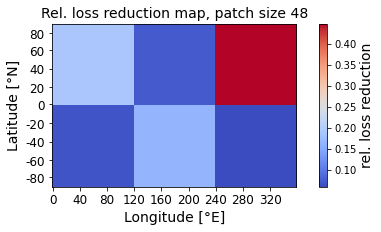

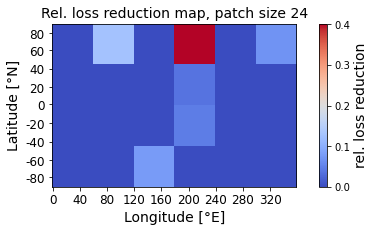

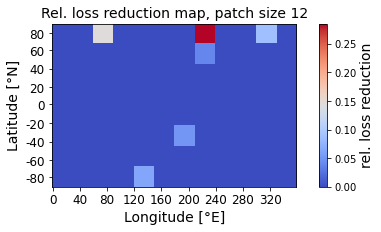

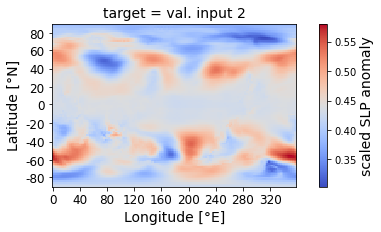

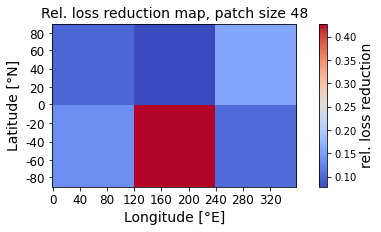

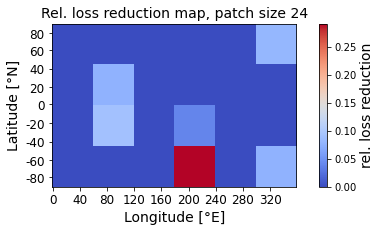

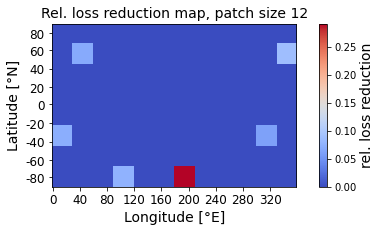

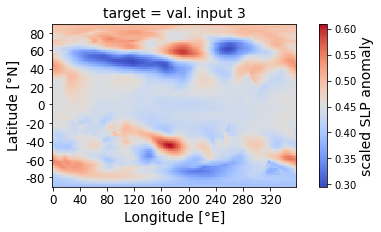

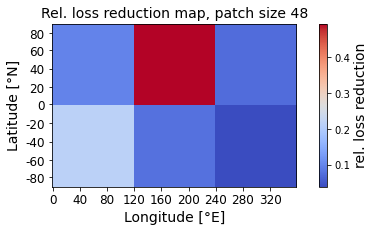

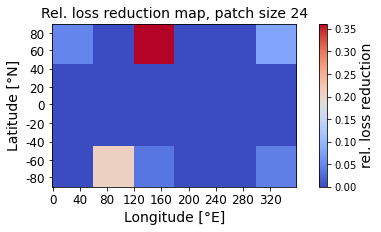

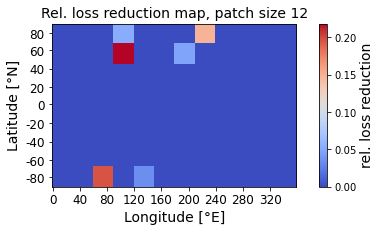

In [24]:
## Show rel. loss reduction maps, serving as relevance maps, for several validation inputs and various patch sizes:

# Define patch sizes:
patch_sizes = [48, 24, 12]

# Define number of validation samples:
n_samples = 4

# Initialize storage for resulting relevance maps, dimension: (#samples, #patch sizes, latitude, longitude)
rel_loss_reduction_maps = np.zeros((n_samples, len(patch_sizes), data.shape[1], data.shape[2]))

# Loop over samples:
for n in range(n_samples):
    
    ## Plot target:

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_input[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)

    plt.title('target = val. input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
       
    plt.show()

    # Loop over patch sizes:
    for p in range(len(patch_sizes)):
        
        # Get current patch size:
        patch_size = patch_sizes[p]
        
        # Compute and store relevance map for current sample and chosen patch size:
        rel_loss_reduction_maps[n,p,:,:] = compute_single_relevance_map(input_sample=val_input[n:n+1], patch_size=patch_size, model=model)    
    
        # Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
        fig, ax = plt.subplots(figsize=(8, 3))
        im = plt.imshow(rel_loss_reduction_maps[n,p,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
        cbar = plt.colorbar(im)
        cbar.set_label('rel. loss reduction', fontsize=14)
        plt.title('Rel. loss reduction map, patch size '+str(patch_size), fontsize=14)
        plt.xlabel('Longitude [°E]', fontsize=14)
        plt.ylabel('Latitude [°N]', fontsize=14)
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
        plt.show()
    

In [ ]:
##### OLD code for early development: Plot masks, patchy inputs and patchy predictions.

In [321]:
## Pick validation sample:
sample = 0

In [322]:
## Create masks for patches, enumerated line-by-line, from left to right, from top to bottom, starting with ONE.

# Specify patch size:
patch_size = 48

# Get number of patches in lat and lon directions, respectively:
n_lat = int(data.shape[1] / patch_size)
n_lon = int(data.shape[2] / patch_size)

# Obtain number of patches:
n_patches = int(n_lat * n_lon)

# Create list of patch indices:
patch_indices = list(np.arange(n_patches))

In [323]:
# Create empty sample of just ZEROs:
empty_sample = np.zeros((1, data.shape[1], data.shape[2]))

## Create patches:

# Initialize storage for patches. Dimension (# of patches, latitude, longitude)
patches = np.zeros((len(patch_indices), data.shape[1], data.shape[2]))

# Run over list of patch indices:
for n in range(len(patch_indices)):
    
    # Get current patch index:
    patch_index = patch_indices[n]
    
    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    
    
    # Store mask for current patch:
    patches[n,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = 1 

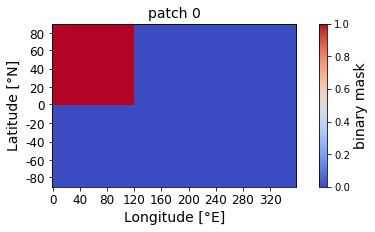

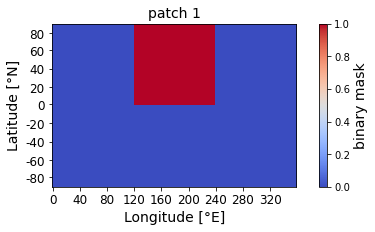

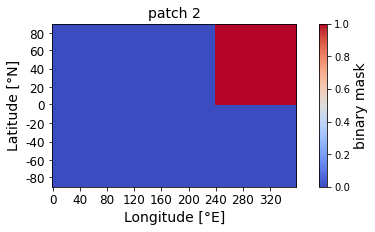

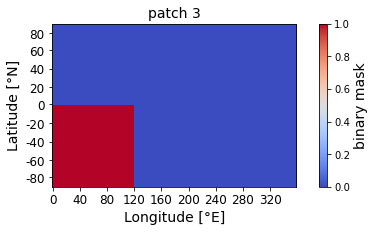

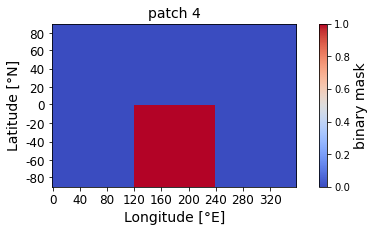

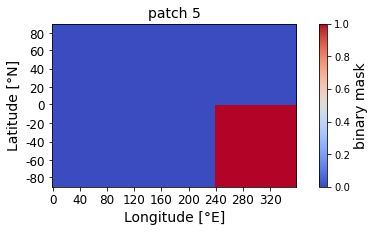

In [324]:
## Plot patches:

for n in range(len(patches)):
    
    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(patches[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("binary mask", fontsize=14)

    plt.title('patch '+str(patch_indices[n]), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

In [325]:
# Expand dimensions of patches: Have last dimension for channel (=1), to match requirements for CNN inputs.
patches_extended = np.expand_dims(patches, axis=-1)
patches_extended.shape

(6, 96, 144, 1)

In [326]:
# Create input samples from first validation sample:
patchy_input = patches_extended * val_input[sample:sample+1]
patchy_input.shape

(6, 96, 144, 1)

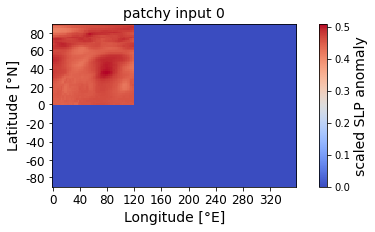

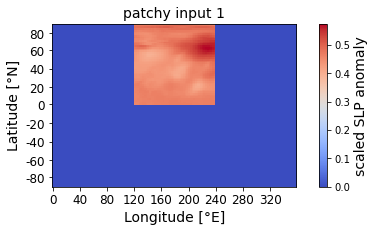

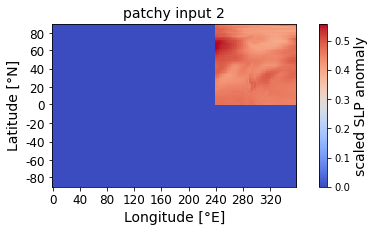

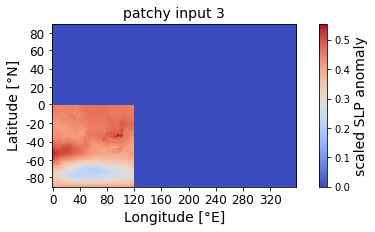

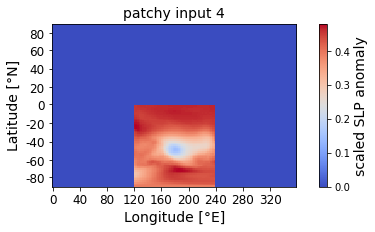

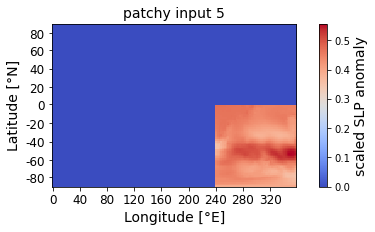

In [327]:
## Plot patchy inputs:

for n in range(len(patchy_input)):
    
    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(patchy_input[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)

    plt.title('patchy input '+str(patch_indices[n]), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

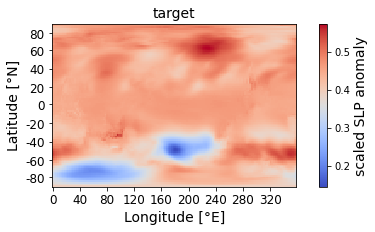

In [328]:
## Plot target:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_input[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("scaled SLP anomaly", fontsize=14)

plt.title('target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

In [329]:
# Get mean state on empty sample as input:
mean_state = model.predict(empty_sample)

# Get model predictions on patchy inputs:
patchy_pred = model.predict(patchy_input)

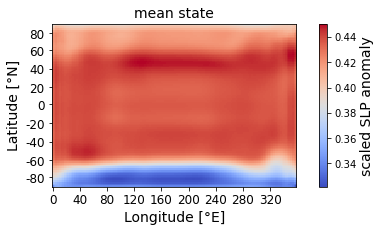

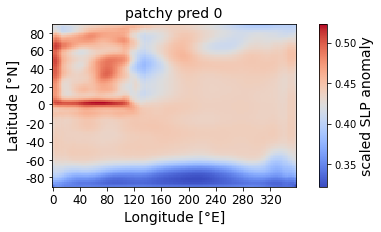

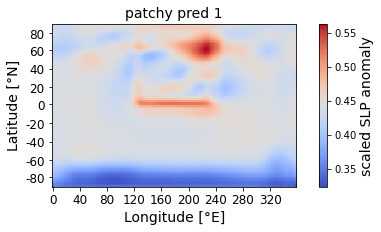

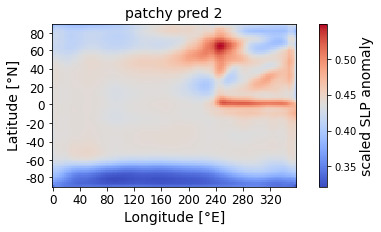

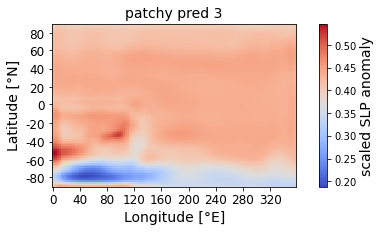

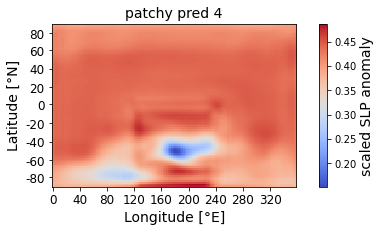

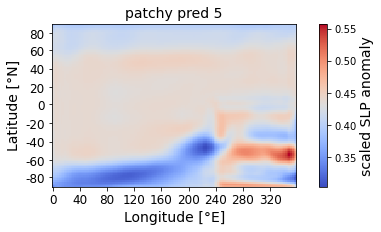

In [330]:
## Plot mean state as prediction on empty sample:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(mean_state[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("scaled SLP anomaly", fontsize=14)

plt.title('mean state', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot model predictions on patchy inputs:

for n in range(len(patchy_pred)):
    
    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(patchy_pred[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)

    plt.title('patchy pred '+str(patch_indices[n]), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

mean state loss:  0.0029933054


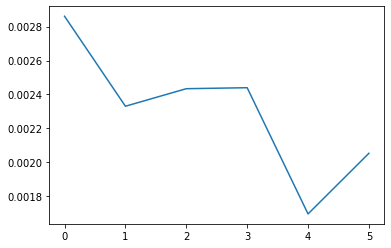

In [331]:
# Compute mean state loss from prediction on empty sample compared to target:
mean_state_loss = np.mean((mean_state[:,:,:,0] - val_target[sample])**2)
print('mean state loss: ', mean_state_loss)

# Compute loss (mean squared error) of patchy predictions compared to targets:
patchy_loss = np.mean((patchy_pred[:,:,:,0] - val_target[sample])**2,axis=(1,2))
plt.plot(patchy_loss)

In [333]:
# Initialize storage for patches ordered by decreasing relevance, absolute and relative loss reduction:
patch_order = []
abs_loss_reduction = []
rel_loss_reduction = []

# get index for patch leading to lowest loss, when adding:
min_index = np.argsort(patchy_loss)[0]

# Save index of first patch, leading to lowest loss:
patch_order.append(patch_indices[min_index])

# Save absolute loss reduction, when adding this patch:
abs_loss_reduction.append(mean_state_loss - patchy_loss[min_index])

# Save loss reduction relative to mean state loss, when adding this patch:
rel_loss_reduction.append((mean_state_loss - patchy_loss[min_index]) / mean_state_loss)

# Fix the previously identified patch with lowest reconstruction loss, as new base patch:
base_patch = patches[min_index]

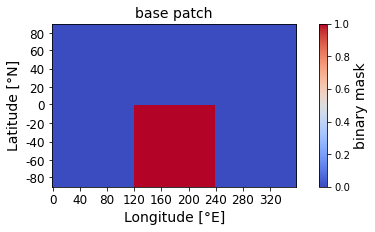

In [334]:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(base_patch, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("binary mask", fontsize=14)

plt.title('base patch', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

In [335]:
## Create new patches:

# Remove previously selected patch from list of patch indices:
patch_indices.remove(patch_indices[min_index])
patch_indices

[0, 1, 2, 3, 5]

In [336]:
# Initialize storage for patches by repeating base patch as often as we have remaining patches.
# Dimensions: (# of remaining patches, latitude, longitude)
patches = np.repeat(np.expand_dims(base_patch,axis=0),len(patch_indices), axis=0)

# Run over list of remaining patch indices:
for n in range(len(patch_indices)):
    
    # Get current patch index:
    patch_index = patch_indices[n]
    
    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    
        
    # Store mask for current patch:
    patches[n,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = 1 

In [337]:
# Create base input from base patch:
base_input = (np.expand_dims(base_patch, axis=-1) * val_input[sample:sample+1])

# Get model prediction on base input:
base_pred = model.predict(base_input)

# Expand dimensions of patches: Have last dimension for channel (=1), to match requirements for CNN inputs.
patches_extended = np.expand_dims(patches, axis=-1)

# Create input samples from first validation sample:
patchy_input = patches_extended * val_input[:1]

# Get model predictions on patchy inputs:
patchy_pred = model.predict(patchy_input)

# Compute loss from prediction on base sample compared to target:
base_loss = np.mean((base_pred[:,:,:,0] - val_target[sample])**2)

# Compute loss (mean squared error) of patchy predictions compared to targets:
patchy_loss = np.mean((patchy_pred[:,:,:,0] - val_target[sample])**2,axis=(1,2))

In [338]:
# get index for patch leading to lowest loss, when adding:
min_index = np.argsort(patchy_loss)[0]

# Save index of first patch, leading to lowest loss:
patch_order.append(patch_indices[min_index])

# Save absolute loss reduction, when adding this patch:
abs_loss_reduction.append(base_loss - patchy_loss[min_index])

# Save loss reduction relative to mean state loss, when adding this patch:
rel_loss_reduction.append((base_loss - patchy_loss[min_index]) / mean_state_loss)

# Fix the previously identified patch with lowest reconstruction loss, as new base patch:
base_patch = patches[min_index]

In [348]:
## Create new patches:

# Remove previously selected patch from list of patch indices:
patch_indices.remove(patch_indices[min_index])

# Initialize storage for patches by repeating base patch as often as we have remaining patches.
# Dimensions: (# of remaining patches, latitude, longitude)
patches = np.repeat(np.expand_dims(base_patch,axis=0),len(patch_indices), axis=0)

# Run over list of remaining patch indices:
for n in range(len(patch_indices)):
    
    # Get current patch index:
    patch_index = patch_indices[n]
    
    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    
        
    # Store mask for current patch:
    patches[n,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = 1 
    
# Create base input from base patch:
base_input = (np.expand_dims(base_patch, axis=-1) * val_input[sample:sample+1])

# Get model prediction on base input:
base_pred = model.predict(base_input)

# Expand dimensions of patches: Have last dimension for channel (=1), to match requirements for CNN inputs.
patches_extended = np.expand_dims(patches, axis=-1)

# Create input samples from first validation sample:
patchy_input = patches_extended * val_input[:1]

# Get model predictions on patchy inputs:
patchy_pred = model.predict(patchy_input)

# Compute loss from prediction on base sample compared to target:
base_loss = np.mean((base_pred[:,:,:,0] - val_target[sample])**2)

# Compute loss (mean squared error) of patchy predictions compared to targets:
patchy_loss = np.mean((patchy_pred[:,:,:,0] - val_target[sample])**2,axis=(1,2))

# get index for patch leading to lowest loss, when adding:
min_index = np.argsort(patchy_loss)[0]

# Save index of first patch, leading to lowest loss:
patch_order.append(patch_indices[min_index])

# Save absolute loss reduction, when adding this patch:
abs_loss_reduction.append(base_loss - patchy_loss[min_index])

# Save loss reduction relative to mean state loss, when adding this patch:
rel_loss_reduction.append((base_loss - patchy_loss[min_index]) / mean_state_loss)

# Fix the previously identified patch with lowest reconstruction loss, as new base patch:
base_patch = patches[min_index]

In [349]:
print('remaining patch indices: ', patch_indices)
print('patch order: ', patch_order)

remaining patch indices:  [2]
patch order:  [4, 1, 5, 3, 0, 2]


In [350]:
abs_loss_reduction

[0.0012980017,
 0.00067559106,
 0.0002760396,
 0.00022299023,
 0.00017199435,
 0.00010961466]

In [351]:
rel_loss_reduction

[0.4336349, 0.22570068, 0.09221899, 0.074496314, 0.057459675, 0.03661994]

In [357]:
## Post-processing of patch order, in combination with rel. loss reduction.
## Aim to have a heat map with original size from input samples in latitude and longitude.
## Grid points for each patch get rel. loss reduction of individual patch as constant value.

# Initialize storage:
rel_loss_reduction_map = np.zeros((data.shape[1], data.shape[2]))

# Run over list containing patch order:
for n in range(len(patch_order)):
  
    # Get current patch index:
    patch_index = patch_order[n]
    
    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    
    
    # Store rel. loss reduction for current patch:
    rel_loss_reduction_map[int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = rel_loss_reduction[n] 
    


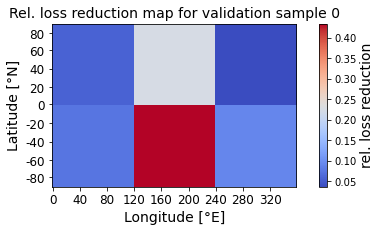

In [366]:
# Plot rel. loss reduction map as heatmap:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("rel. loss reduction", fontsize=14)

plt.title('Rel. loss reduction map for validation sample '+str(sample), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()